## Overview
* Country: United States, France, Germany, Japan, United Kingdom, Italy, Canada
* Time period: 1950-2018, 69 years
* Target variable: `ngdp_rpch` for annual data, `ngdp_r_sa_pcha` and `ngdp_r_sa_pchy` (respectively) for quarterly data
* Train-test split: 1950-2009 (train, ≤ x  years, depends on data availability), x - y (test, z years)   
  _Need further discussion. Here I divide the dataset by x/y just as the working paper did. Now for the ML model family we do not need to do such split._
  
* LSTM Model
* CNN Model

## Import packages

In [1]:
# Module 1: Importing the libraries

import tensorflow as tf
from tensorflow import keras
keras = tf.keras

# Print all outputs in a code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Importing the libraries
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


# from tf.random import set_seed

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from keras.callbacks import ModelCheckpoint

# from keras.callbacks import ResetStatesCallback()

from keras.layers import Conv1D
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten,Dense
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
from tensorflow import random
# from tensorflow.random import set_seed

In [4]:
# Set Seed

seed_global = 42

# Source: https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

from numpy.random import seed
seed(seed_global)

#  Giving an eror 
# from tensorflow import set_random_seed
# set_random_seed(seed_global)

# Source: https://stackoverflow.com/questions/58638701/importerror-cannot-import-name-set-random-seed-from-tensorflow-c-users-po

tf.random.set_seed(seed_global)

# Copy paste this code snippet in every model code chunk 
seed(seed_global)
tf.random.set_seed(seed_global)

# --Ignore--
# tf.random.set_seed(seed)
# # This is giving me an error

# #  Global Seed
# # random.seed (2019) 

## Get data

In [5]:
%%bigquery gdp_quarterly_q

SELECT *
FROM `deep-nexus.temp_for_imf_data.WEO_G7_Quarterly`
ORDER BY time

In [6]:
gdp_quarterly_q.year = (gdp_quarterly_q.time+40)//4 + 1950
gdp_quarterly_q.quarter = (gdp_quarterly_q.time+40)%4 + 1
gdp_quarterly_q.time = gdp_quarterly_q.year.astype('str') + 'Q' + gdp_quarterly_q.quarter.astype('str')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [7]:
gdp_quarterly_q = pd.DataFrame(gdp_quarterly_q)
gdp_quarterly_q.head(5)

,country,ifscode,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,...,pcpi_sa,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt
0,United States,111,1950Q1,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
1,United Kingdom,112,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,72.776393,NaN,72.776393,NaN,NaN,NaN,NaN
2,France,132,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,47.016824,NaN,47.016824,NaN,NaN,NaN,NaN
3,Germany,134,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Italy,136,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Selecting a subset of countries
gdp_quarterly_q.country.unique()

selected_countries = list(gdp_quarterly_q.country.unique())[0:1]
print("\nSelected Countries: \n")
selected_countries

array(['United States', 'United Kingdom', 'France', 'Germany', 'Italy',
       'Canada', 'Japan'], dtype=object)


Selected Countries: 



['United States']

In [9]:
# dataset_2 = gdp_quarterly_q

# for i in selected_countries:
#    dataset_2[i] = gdp_quarterly_q[gdp_quarterly_q['country'] == i]

# https://stackoverflow.com/questions/51583888/concatenate-dataframe-name-with-variable-value-python

In [10]:
# # Random Forest Regressor

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# # random forest model creation

# # Set Seed
# seed(seed_global)
# tensorflow.random.set_seed(seed_global)


# rfr = RandomForestRegressor(n_estimators = 1000)

# rfr.fit(X_train, y_train)

# # predictions
# y_pred = rfr.predict(X_test)

# metrics_mse["random_forest"] =  mean_squared_error(y_test, y_pred)

# print("Random Forest Test MSE: ", mean_squared_error(y_test, y_pred))

In [11]:
# # Variable Importance

# # Top i factors by importance

# i = 20
# importances = rf_reg.feature_importances_
# indices = np.argsort(importances)[-(i-1):]
# features = X.columns

# plt.figure(figsize=(6,6))
# plt.title('Feature Importances - Random Forest Regressor')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance')

In [12]:
# Filter data by country

dataset = gdp_quarterly_q[gdp_quarterly_q['country'].isin(selected_countries)]

dataset = pd.DataFrame(dataset)
# print ("#", "column name", "missing values")
# for i in range(len(dataset.columns)):
#     print(i, dataset.columns[i], " ", dataset.iloc[i].isnull().count())

dataset.head(5)

,country,ifscode,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,...,pcpi_sa,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt
0,United States,111,1950Q1,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
7,United States,111,1950Q2,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
14,United States,111,1950Q3,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
21,United States,111,1950Q4,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
28,United States,111,1951Q1,NaN,NaN,NaN,0.062002,NaN,NaN,NaN,...,NaN,NaN,NaN,348.993057,NaN,348.993057,8.709073,11.508033,10.159067,12.875869


## Variable selection

In [13]:
# Variable selection

# Input Columns
# Selecting 10 variables

dataset_input = dataset

dataset_input = dataset_input.drop(columns = ['country', 'ifscode', 'time', 'ngdp_r_sa_pcha', 'ngdp_r_sa_pchy', 'ngdp_dpchy'])

# Dropped ngdp_dpchy as all values are null

dataset_input.tail(5)

,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,247.273333,3.141889,2.109865,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,249.250333,3.236639,2.222997,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,250.578667,2.148827,2.668825,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,251.828667,2.010362,2.632912,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725
1925,18819.741667,11057.4,156.776667,0.162071,111.370,3.800000,2605.7,-0.011512,13066.3,0.357148,...,252.759000,1.485933,2.218463,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725


In [14]:
# Outcome vaiable (Column Name) = ngdp_r_sa_pcha

outcome_variable = "ngdp_r_sa_pcha"
predicted_variable = "1_step_ahead_" + outcome_variable

dataset_1 = dataset_input
dataset_1["time"] = dataset["time"]
# dataset_1[num_cols] = dataset[num_cols]
dataset_1[outcome_variable] = dataset[outcome_variable]

dataset_1[predicted_variable] = dataset_1[outcome_variable].shift(-1)

# # Source: https://stackoverflow.com/questions/20095673/shift-column-in-pandas-dataframe-up-by-one

dataset_1 = dataset_1[:-1] 

dataset_1.tail(5)

,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,time,ngdp_r_sa_pcha,1_step_ahead_ngdp_r_sa_pcha
1890,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,12586.3,0.586595,...,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,2017Q3,3.202964,3.545494
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,2017Q4,3.545494,2.552107
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2018Q1,2.552107,3.512025
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2018Q2,3.512025,2.926498
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2018Q3,2.926498,1.089155


In [15]:
# Output Columns

# ngdp_r_sa_pcha: WEO: Gross domestic product, constant prices, seasonally adjusted, quarter-over-quarter percent change, annualized (Percent, Units).

dataset_Y = dataset_1[["time", predicted_variable]]
dataset_Y.tail(5)

,time,1_step_ahead_ngdp_r_sa_pcha
1890,2017Q3,3.545494
1897,2017Q4,2.552107
1904,2018Q1,3.512025
1911,2018Q2,2.926498
1918,2018Q3,1.089155


In [16]:
# Window size and crearting the lagged columns

#  Using a lag = 0 for identifying initial variable importance by fitting a randowm forest 
# window size 
lag = 0
dataset_input_l = dataset_1

# Drop the 1) preducted outcome variable and 2) time variable 

dataset_input_l = dataset_input_l.drop(columns = ["time", predicted_variable])

print("Before adding the lagged variables to the input dataset: ")
dataset_input_l.tail(5)

# Lagging each column in num_columns by the entire range of lag factors

for j in dataset_input_l.columns:
    for i in range(1, (lag + 1), 1):
        new_col = str(j)+"-"+str(i)
        dataset_input_l[str(new_col)] = dataset_input_l[str(j)].shift(i)
    
print("After adding the lagged variables to the input dataset: ")
dataset_input_l.tail(5)

Before adding the lagged variables to the input dataset: 


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
1890,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,12586.3,0.586595,...,2.153214,1.981427,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.202964
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,3.141889,2.109865,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.545494
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,3.236639,2.222997,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.552107
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,2.148827,2.668825,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,3.512025
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,2.010362,2.632912,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.926498


After adding the lagged variables to the input dataset: 


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
1890,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,12586.3,0.586595,...,2.153214,1.981427,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.202964
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,3.141889,2.109865,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.545494
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,3.236639,2.222997,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.552107
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,2.148827,2.668825,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,3.512025
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,2.010362,2.632912,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.926498


In [17]:
# Combining Input and Output Values

# X1 = dataset_input
# X = pd.concat([X1, X2, dataset_Y], axis=1)
X = pd.concat([dataset_Y, dataset_input_l], axis=1)
X.head(5)
X.shape

print("\nColumns names:\n")
X.columns

,time,1_step_ahead_ngdp_r_sa_pcha,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
0,1950Q1,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN,NaN
7,1950Q2,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN,NaN
14,1950Q3,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN,NaN
21,1950Q4,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN,NaN
28,1951Q1,NaN,NaN,NaN,NaN,0.062002,NaN,NaN,NaN,NaN,...,NaN,NaN,348.993057,NaN,348.993057,8.709073,11.508033,10.159067,12.875869,NaN


(275, 63)


Columns names:



Index(['time', '1_step_ahead_ngdp_r_sa_pcha', 'gdpwgt', 'lc', 'le', 'llf',
       'lulcm', 'lur', 'ncg_r', 'ncg_rpch', 'ncp_r', 'ncp_rpch', 'ncp_rpchy',
       'nfbrgdp', 'nfb_r', 'nfdd_r', 'nfdd_rpch', 'nfie_r', 'nfisn_r',
       'nfisr_r', 'nfis_r', 'nfi_r', 'nfi_rpch', 'ngdp', 'ngdp_d', 'ngdp_dpch',
       'ngdp_d_sa', 'ngdp_d_sa_pchy', 'ngdp_r', 'ngdp_rpch', 'ngdp_rpchy',
       'ngdp_r_sa', 'ngdp_r_sa_ar', 'ngdp_sa', 'ngdp_sa_ar', 'nmg_r',
       'nmg_rpch', 'nms_r', 'nm_r', 'nm_rpch', 'nshr', 'ntdd_r', 'ntdd_rpch',
       'ntdd_rpchy', 'nxg_r', 'nxg_rpch', 'nxs_r', 'nx_r', 'nx_rpch', 'pcpi',
       'pcpi_pch', 'pcpi_pchy', 'pcpi_sa', 'pcpi_sa_pcha', 'pcpi_sa_pchy',
       'pppgdp', 'pppsh', 'pppwgt', 'tmgwgt', 'tmwgt', 'txgwgt', 'txwgt',
       'ngdp_r_sa_pcha'],
      dtype='object')

In [18]:
# Dropping all rows with missing data
print("\nAfter dropping rows with missing data")
# X = X.iloc[lag:]
# X = X.iloc[:-1]
X = X.dropna()
X.shape
X.head(5)
X.tail(5)


After dropping rows with missing data


(155, 63)

,time,1_step_ahead_ngdp_r_sa_pcha,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
840,1980Q1,-7.985864,2352.456802,1573.6,99.862333,0.106979,77.648,6.300000,1447.3,0.885264,...,16.741448,14.210019,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,1.261758
847,1980Q2,-0.476985,2352.456802,1599.2,98.953333,0.106979,80.939,7.333333,1467.3,1.381884,...,14.194984,14.425770,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-7.985864
854,1980Q3,7.668385,2352.456802,1628.6,98.899000,0.106979,83.201,7.666667,1452.7,-0.995025,...,7.721136,12.935323,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-0.476985
861,1980Q4,8.070747,2352.456802,1687.6,99.498667,0.106979,84.538,7.400000,1449.5,-0.220279,...,11.693861,12.538360,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,7.668385
868,1981Q1,-2.926867,2611.683590,1739.6,100.239000,0.108677,86.287,7.433333,1461.0,0.793377,...,11.531024,11.261071,3207.025,21.713333,3207.025,248.575,293.825,230.425,280.775,8.070747


,time,1_step_ahead_ngdp_r_sa_pcha,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
1890,2017Q3,3.545494,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,...,2.153214,1.981427,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.202964
1897,2017Q4,2.552107,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,...,3.141889,2.109865,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.545494
1904,2018Q1,3.512025,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,...,3.236639,2.222997,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.552107
1911,2018Q2,2.926498,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,...,2.148827,2.668825,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,3.512025
1918,2018Q3,1.089155,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,...,2.010362,2.632912,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.926498


## Process data

In [19]:
# Separating input and output variables

X1 = X

Y1 = X1[predicted_variable]

Y1 = pd.DataFrame(Y1) # very important step, gave me formatting errors, and wasted 2 hour in debugging   

print("\n Outcome variable dimension", Y1.shape)
Y1.shape
Y1.head(5)

# Dropping outcome variable from input matrix
X1 = X1.drop(columns = [predicted_variable])
print("\n Input matrix: X")
X1.shape
X1.head(5)

print("\n columns in input dataset\n:")
X1.columns


 Outcome variable dimension (155, 1)


(155, 1)

,1_step_ahead_ngdp_r_sa_pcha
840,-7.985864
847,-0.476985
854,7.668385
861,8.070747
868,-2.926867



 Input matrix: X


(155, 62)

,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
840,1980Q1,2352.456802,1573.6,99.862333,0.106979,77.648,6.300000,1447.3,0.885264,4277.9,...,16.741448,14.210019,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,1.261758
847,1980Q2,2352.456802,1599.2,98.953333,0.106979,80.939,7.333333,1467.3,1.381884,4181.5,...,14.194984,14.425770,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-7.985864
854,1980Q3,2352.456802,1628.6,98.899000,0.106979,83.201,7.666667,1452.7,-0.995025,4227.4,...,7.721136,12.935323,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-0.476985
861,1980Q4,2352.456802,1687.6,99.498667,0.106979,84.538,7.400000,1449.5,-0.220279,4284.5,...,11.693861,12.538360,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,7.668385
868,1981Q1,2611.683590,1739.6,100.239000,0.108677,86.287,7.433333,1461.0,0.793377,4298.8,...,11.531024,11.261071,3207.025,21.713333,3207.025,248.575,293.825,230.425,280.775,8.070747



 columns in input dataset
:


Index(['time', 'gdpwgt', 'lc', 'le', 'llf', 'lulcm', 'lur', 'ncg_r',
       'ncg_rpch', 'ncp_r', 'ncp_rpch', 'ncp_rpchy', 'nfbrgdp', 'nfb_r',
       'nfdd_r', 'nfdd_rpch', 'nfie_r', 'nfisn_r', 'nfisr_r', 'nfis_r',
       'nfi_r', 'nfi_rpch', 'ngdp', 'ngdp_d', 'ngdp_dpch', 'ngdp_d_sa',
       'ngdp_d_sa_pchy', 'ngdp_r', 'ngdp_rpch', 'ngdp_rpchy', 'ngdp_r_sa',
       'ngdp_r_sa_ar', 'ngdp_sa', 'ngdp_sa_ar', 'nmg_r', 'nmg_rpch', 'nms_r',
       'nm_r', 'nm_rpch', 'nshr', 'ntdd_r', 'ntdd_rpch', 'ntdd_rpchy', 'nxg_r',
       'nxg_rpch', 'nxs_r', 'nx_r', 'nx_rpch', 'pcpi', 'pcpi_pch', 'pcpi_pchy',
       'pcpi_sa', 'pcpi_sa_pcha', 'pcpi_sa_pchy', 'pppgdp', 'pppsh', 'pppwgt',
       'tmgwgt', 'tmwgt', 'txgwgt', 'txwgt', 'ngdp_r_sa_pcha'],
      dtype='object')

In [20]:
# Random Forest

# Sequential train-test split
train_test_ratio = 0.69

training = int(round(X1.shape[0]*train_test_ratio, 0))
test = X1.shape[0] - training

print("# items in training set:", training)
print("\n# items in test set:", test)

X_train = X1.iloc[0:(training),:]
y_train = Y1.iloc[0:(training),0]
X_test = X1.iloc[training:(X1.shape[0]),:]
y_test = Y1.iloc[training:(X1.shape[0]),0]
y_test_outcome_value = Y1.iloc[training:(X1.shape[0]),:]

print("\n input training set:")
X_train.shape
X_train.head(5)

y_train.head(5)

print("\n input test set:")
X_test.shape
X_test.head(5)

y_test.head(5)
y_test_outcome_value.head(5)

# items in training set: 107

# items in test set: 48

 input training set:


(107, 62)

,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
840,1980Q1,2352.456802,1573.6,99.862333,0.106979,77.648,6.300000,1447.3,0.885264,4277.9,...,16.741448,14.210019,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,1.261758
847,1980Q2,2352.456802,1599.2,98.953333,0.106979,80.939,7.333333,1467.3,1.381884,4181.5,...,14.194984,14.425770,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-7.985864
854,1980Q3,2352.456802,1628.6,98.899000,0.106979,83.201,7.666667,1452.7,-0.995025,4227.4,...,7.721136,12.935323,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-0.476985
861,1980Q4,2352.456802,1687.6,99.498667,0.106979,84.538,7.400000,1449.5,-0.220279,4284.5,...,11.693861,12.538360,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,7.668385
868,1981Q1,2611.683590,1739.6,100.239000,0.108677,86.287,7.433333,1461.0,0.793377,4298.8,...,11.531024,11.261071,3207.025,21.713333,3207.025,248.575,293.825,230.425,280.775,8.070747


840   -7.985864
847   -0.476985
854    7.668385
861    8.070747
868   -2.926867
Name: 1_step_ahead_ngdp_r_sa_pcha, dtype: float64


 input test set:


(48, 62)

,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
1589,2006Q4,12236.20,7624.0,145.606000,0.151394,96.534,4.433333,2443.5,0.846059,10504.5,...,-1.630622,1.965396,13814.600,18.732023,13814.600,1715.450,2026.425,921.925,1305.225,3.449636
1596,2007Q1,13021.65,7806.8,146.135000,0.153119,96.994,4.500000,2444.9,0.057295,10563.3,...,3.979630,2.431651,14451.875,18.104068,14451.875,1895.725,2243.550,1044.925,1472.600,0.945307
1603,2007Q2,13021.65,7845.4,145.850667,0.153119,95.793,4.500000,2460.5,0.638063,10582.8,...,4.607759,2.665287,14451.875,18.104068,14451.875,1895.725,2243.550,1044.925,1472.600,2.312389
1610,2007Q3,13021.65,7885.1,145.943667,0.153119,95.084,4.666667,2472.8,0.499898,10642.5,...,2.556194,2.348975,14451.875,18.104068,14451.875,1895.725,2243.550,1044.925,1472.600,2.189473
1617,2007Q4,13021.65,7978.2,146.271333,0.153119,94.925,4.800000,2489.1,0.659172,10672.8,...,4.997587,4.031137,14451.875,18.104068,14451.875,1895.725,2243.550,1044.925,1472.600,2.455478


1589    0.945307
1596    2.312389
1603    2.189473
1610    2.455478
1617   -2.279453
Name: 1_step_ahead_ngdp_r_sa_pcha, dtype: float64

,1_step_ahead_ngdp_r_sa_pcha
1589,0.945307
1596,2.312389
1603,2.189473
1610,2.455478
1617,-2.279453


In [21]:
# Scaling the training & test sets 

# Dropping the "time" column

X_train.drop(columns = ['time'], inplace = True)
X_test.drop(columns = ['time'], inplace = True)

train_columns = list(X_train.columns)
# train_columns

# X_test  = X_test.drop(columns = ["time"], inplace = True)

X_train.head(5)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
840,2352.456802,1573.6,99.862333,0.106979,77.648,6.300000,1447.3,0.885264,4277.9,-0.142390,...,16.741448,14.210019,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,1.261758
847,2352.456802,1599.2,98.953333,0.106979,80.939,7.333333,1467.3,1.381884,4181.5,-2.253442,...,14.194984,14.425770,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-7.985864
854,2352.456802,1628.6,98.899000,0.106979,83.201,7.666667,1452.7,-0.995025,4227.4,1.097692,...,7.721136,12.935323,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,-0.476985
861,2352.456802,1687.6,99.498667,0.106979,84.538,7.400000,1449.5,-0.220279,4284.5,1.350712,...,11.693861,12.538360,2857.325,21.531397,2857.325,212.800,252.675,187.275,230.150,7.668385
868,2611.683590,1739.6,100.239000,0.108677,86.287,7.433333,1461.0,0.793377,4298.8,0.333761,...,11.531024,11.261071,3207.025,21.713333,3207.025,248.575,293.825,230.425,280.775,8.070747


In [22]:
# Scaling all the numerical variables
scaler = MinMaxScaler()

# train_columns = list(X_train.columns) # removing 'time' column for feature scaling
# train_columns


print("\nScaled training input dataset:")
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = train_columns)

X_train.head(5)

print("\nScaled test input dataset:")
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns = train_columns)

X_test.head(5)


Scaled training input dataset:


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
0,0.000000,0.000000,0.021103,0.000000,0.000000,0.354680,0.000000,0.731506,0.015493,0.492115,...,1.000000,0.983648,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.00000,0.531239
1,0.000000,0.004329,0.001190,0.000000,0.120993,0.507389,0.020435,0.835901,0.000000,0.000000,...,0.863638,1.000000,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,0.000000,0.009301,0.000000,0.000000,0.204154,0.556650,0.005518,0.336250,0.007377,0.781195,...,0.516968,0.887036,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.00000,0.431355
3,0.000000,0.019278,0.013137,0.000000,0.253309,0.517241,0.002248,0.499109,0.016553,0.840178,...,0.729705,0.856949,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.00000,0.899275
4,0.026228,0.028071,0.029355,0.038232,0.317610,0.522167,0.013998,0.712191,0.018852,0.603113,...,0.720985,0.760141,0.031915,0.811984,0.031915,0.023808,0.023199,0.058735,0.04709,0.922389



Scaled test input dataset:


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
0,0.000000,0.000000,0.413340,0.000000,0.095128,0.103261,0.019358,0.782466,0.033506,0.885535,...,0.476190,0.520792,0.000000,1.000000,0.000000,0.161348,0.050333,0.000000,0.000000,0.850587
1,0.119305,0.054238,0.443550,0.161546,0.122325,0.114130,0.025968,0.525182,0.056100,0.695181,...,0.846199,0.588765,0.094193,0.822434,0.094193,0.384966,0.278011,0.177483,0.156942,0.670491
2,0.119305,0.065691,0.427312,0.161546,0.051318,0.114130,0.099622,0.714620,0.063593,0.520215,...,0.887625,0.622825,0.094193,0.822434,0.094193,0.384966,0.278011,0.177483,0.156942,0.768803
3,0.119305,0.077471,0.432623,0.161546,0.009400,0.141304,0.157696,0.669553,0.086532,0.697215,...,0.752320,0.576712,0.094193,0.822434,0.094193,0.384966,0.278011,0.177483,0.156942,0.759964
4,0.119305,0.105095,0.451335,0.161546,0.000000,0.163043,0.234655,0.721506,0.098175,0.566902,...,0.913335,0.821944,0.094193,0.822434,0.094193,0.384966,0.278011,0.177483,0.156942,0.779093


In [23]:
if 'time' in X_train.columns:
    print("Does not exist")
else:
    print("Does not exist")
    
X_train

# train_cols = X_train.columns

# train_cols

Does not exist


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
0,0.000000,0.000000,0.021103,0.000000,0.000000,0.354680,0.000000,0.731506,0.015493,0.492115,...,1.000000,0.983648,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.000000,0.531239
1,0.000000,0.004329,0.001190,0.000000,0.120993,0.507389,0.020435,0.835901,0.000000,0.000000,...,0.863638,1.000000,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.009301,0.000000,0.000000,0.204154,0.556650,0.005518,0.336250,0.007377,0.781195,...,0.516968,0.887036,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.000000,0.431355
3,0.000000,0.019278,0.013137,0.000000,0.253309,0.517241,0.002248,0.499109,0.016553,0.840178,...,0.729705,0.856949,0.000000,0.762432,0.000000,0.000000,0.000000,0.000000,0.000000,0.899275
4,0.026228,0.028071,0.029355,0.038232,0.317610,0.522167,0.013998,0.712191,0.018852,0.603113,...,0.720985,0.760141,0.031915,0.811984,0.031915,0.023808,0.023199,0.058735,0.047090,0.922389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.929171,0.938396,0.950484,0.952835,0.662904,0.157635,0.975886,0.634163,0.958456,0.751513,...,0.435381,0.196149,0.928999,0.123489,0.928999,0.861511,0.870486,0.874804,0.881311,0.666370
103,0.929171,0.953226,0.957333,0.952835,0.640515,0.157635,0.976499,0.550664,0.963293,0.594471,...,0.306060,0.185154,0.928999,0.123489,0.928999,0.861511,0.870486,0.874804,0.881311,0.605169
104,1.000000,0.981906,0.975947,1.000000,0.709081,0.123153,1.000000,0.746615,0.981534,0.785331,...,0.215922,0.186381,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.770543
105,1.000000,0.990006,0.989492,1.000000,0.693934,0.108374,0.993154,0.487360,0.989907,0.643350,...,0.299431,0.204070,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.512677


## Original features corr

In [23]:
import seaborn as sns

In [24]:
x_corr = X_train.corr()

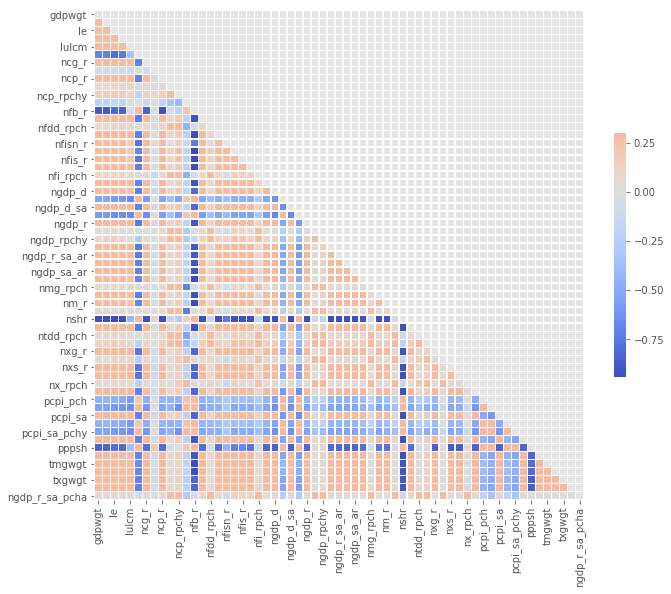

In [25]:
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(x_corr, dtype=np.bool))
sns.heatmap(x_corr, mask=mask, vmax=.3, center=0, cmap= 'coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## PCA

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [27]:
samples = X_train.dropna()

In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(samples)

In [29]:
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X)

In [30]:
new_X = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2', 'PC3', 
                                                    'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
new_X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,10.726139,5.229944,6.720187,-1.085443,0.409398,-0.271607,-0.105638,0.451460,0.614561,0.406267
1,11.806576,13.836293,2.039114,-2.946590,1.258409,-2.219601,0.264671,-0.716687,-1.465558,0.718899
2,10.741595,7.017178,1.529121,0.766568,1.078412,4.780616,1.054635,-0.995915,1.403312,0.192651
3,10.137535,0.287033,6.541474,3.552444,-2.358330,2.161206,-1.087223,1.177302,1.462809,-1.103499
4,9.786145,0.928676,6.299913,1.361927,-1.396843,0.839819,-1.705807,1.284843,-0.316235,-0.887802


<BarContainer object of 10 artists>

Text(0, 0.5, 'percentange of explained variance')

Text(0.5, 0, 'principal component')

Text(0.5, 1.0, 'variable importance')

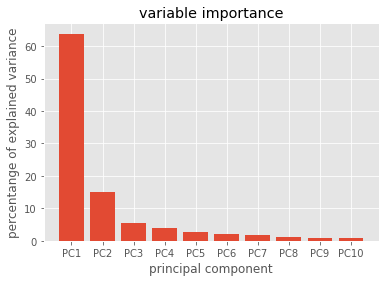

In [31]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('percentange of explained variance')
plt.xlabel('principal component')
plt.title('variable importance')
plt.show()

In [32]:
per_var

array([63.83, 14.9 ,  5.57,  4.05,  2.63,  2.11,  1.67,  1.29,  0.92,
        0.82])

In [31]:
per_var.sum()

97.79

## Transformed features corr

In [33]:
corr = pca.get_covariance()

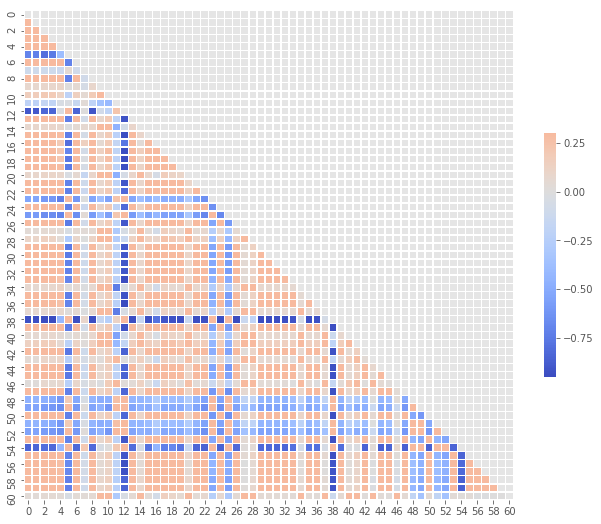

In [34]:
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, vmax=.3, center=0, cmap= 'coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## PC loadings (loading matrix)

In [35]:
pca.components_.shape

(10, 61)

In [36]:
pca.explained_variance_.shape

(10,)

In [37]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [38]:
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 
                                              'PC8', 'PC9', 'PC10'])
df_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.996530,0.094729,0.029371,0.017884,-0.038671,0.019061,-0.019003,-0.031869,-0.030870,0.010420
1,-0.997851,0.097977,0.041647,0.021582,-0.018868,0.011370,-0.008844,-0.012014,-0.014039,0.005219
2,-0.992566,0.057538,-0.025118,-0.076529,-0.020542,-0.000499,0.013958,0.100713,0.028681,-0.009945
3,-0.996291,0.056025,-0.046037,-0.041615,-0.052734,0.014304,-0.003615,0.052416,-0.009547,0.003005
4,-0.429154,-0.171526,-0.619225,-0.213103,-0.308070,0.057875,0.024634,0.386399,-0.026655,0.064999
...,...,...,...,...,...,...,...,...,...,...
56,-0.972528,0.168897,0.103824,0.077108,0.021438,0.014294,-0.028654,-0.074320,-0.019782,-0.000121
57,-0.975066,0.164802,0.098254,0.069110,0.014590,0.016689,-0.028633,-0.072408,-0.021757,0.000408
58,-0.975877,0.120872,0.022785,0.085874,-0.047957,0.017963,0.010904,0.085570,0.001804,0.070322
59,-0.981487,0.114697,0.021076,0.070297,-0.052366,0.022212,0.010788,0.073632,-0.003022,0.067205


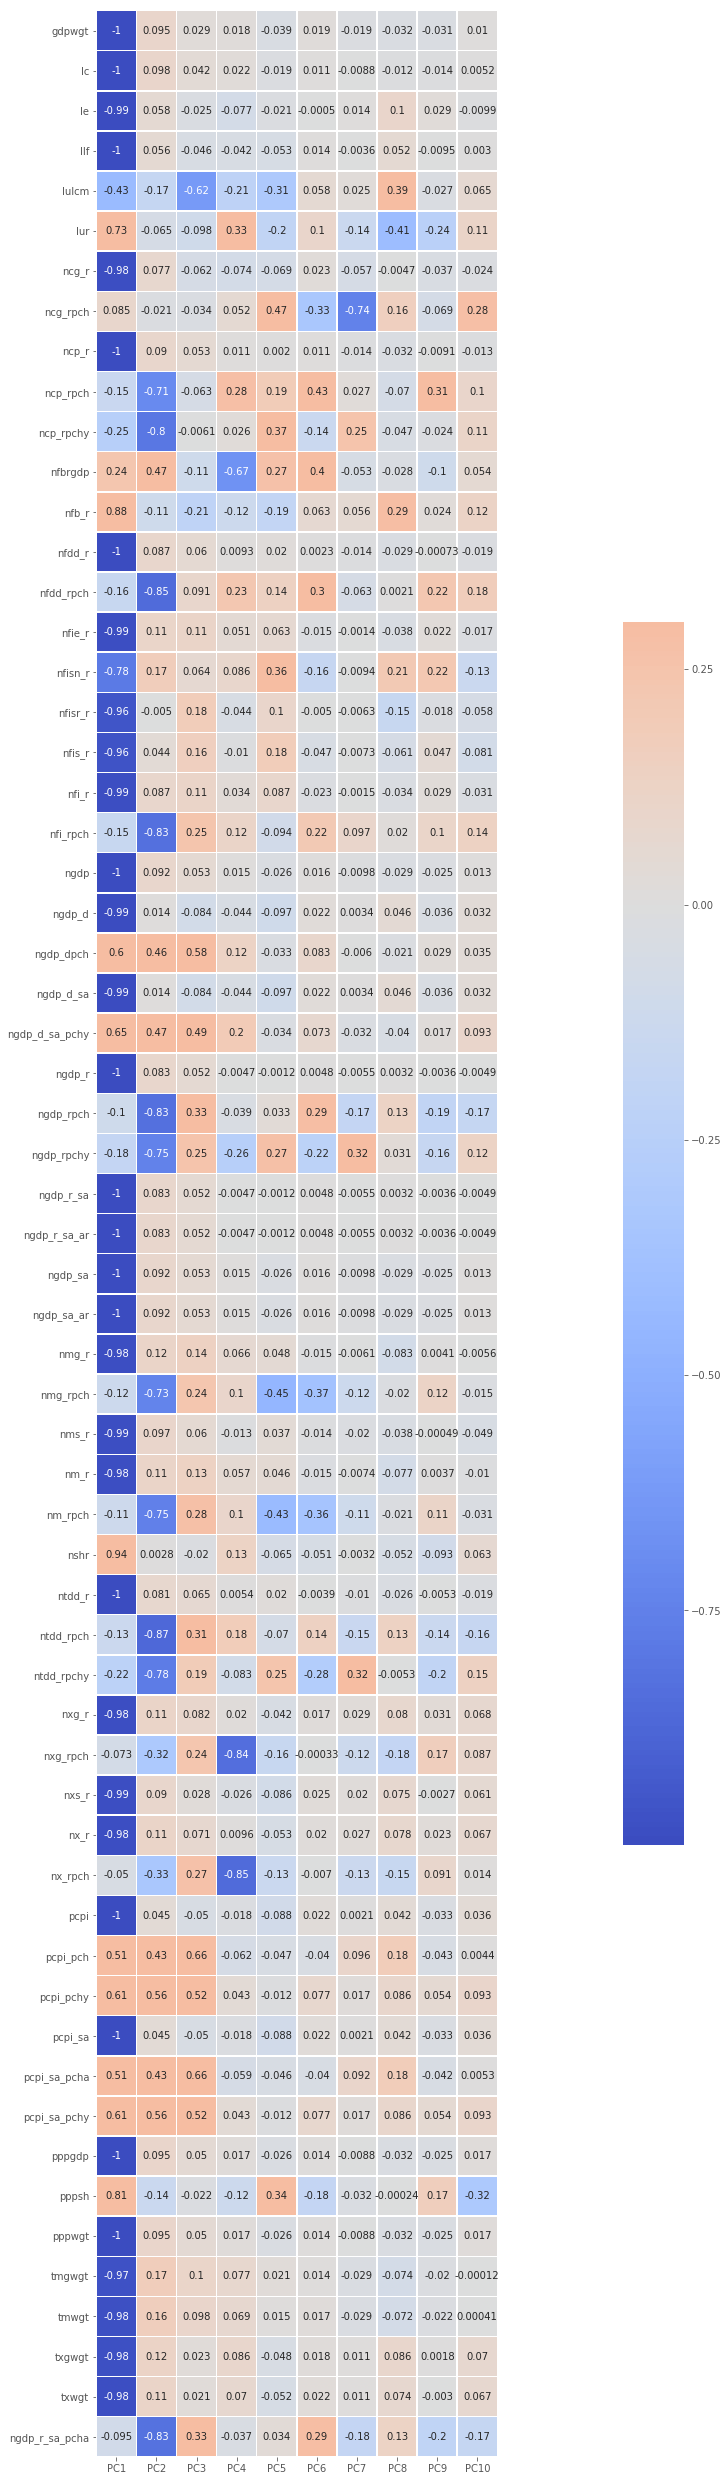

In [39]:
f, ax = plt.subplots(figsize=(45,45))
sns.heatmap(loadings, vmax=.3, center=0, cmap= 'coolwarm', annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
            yticklabels=X_train.columns)

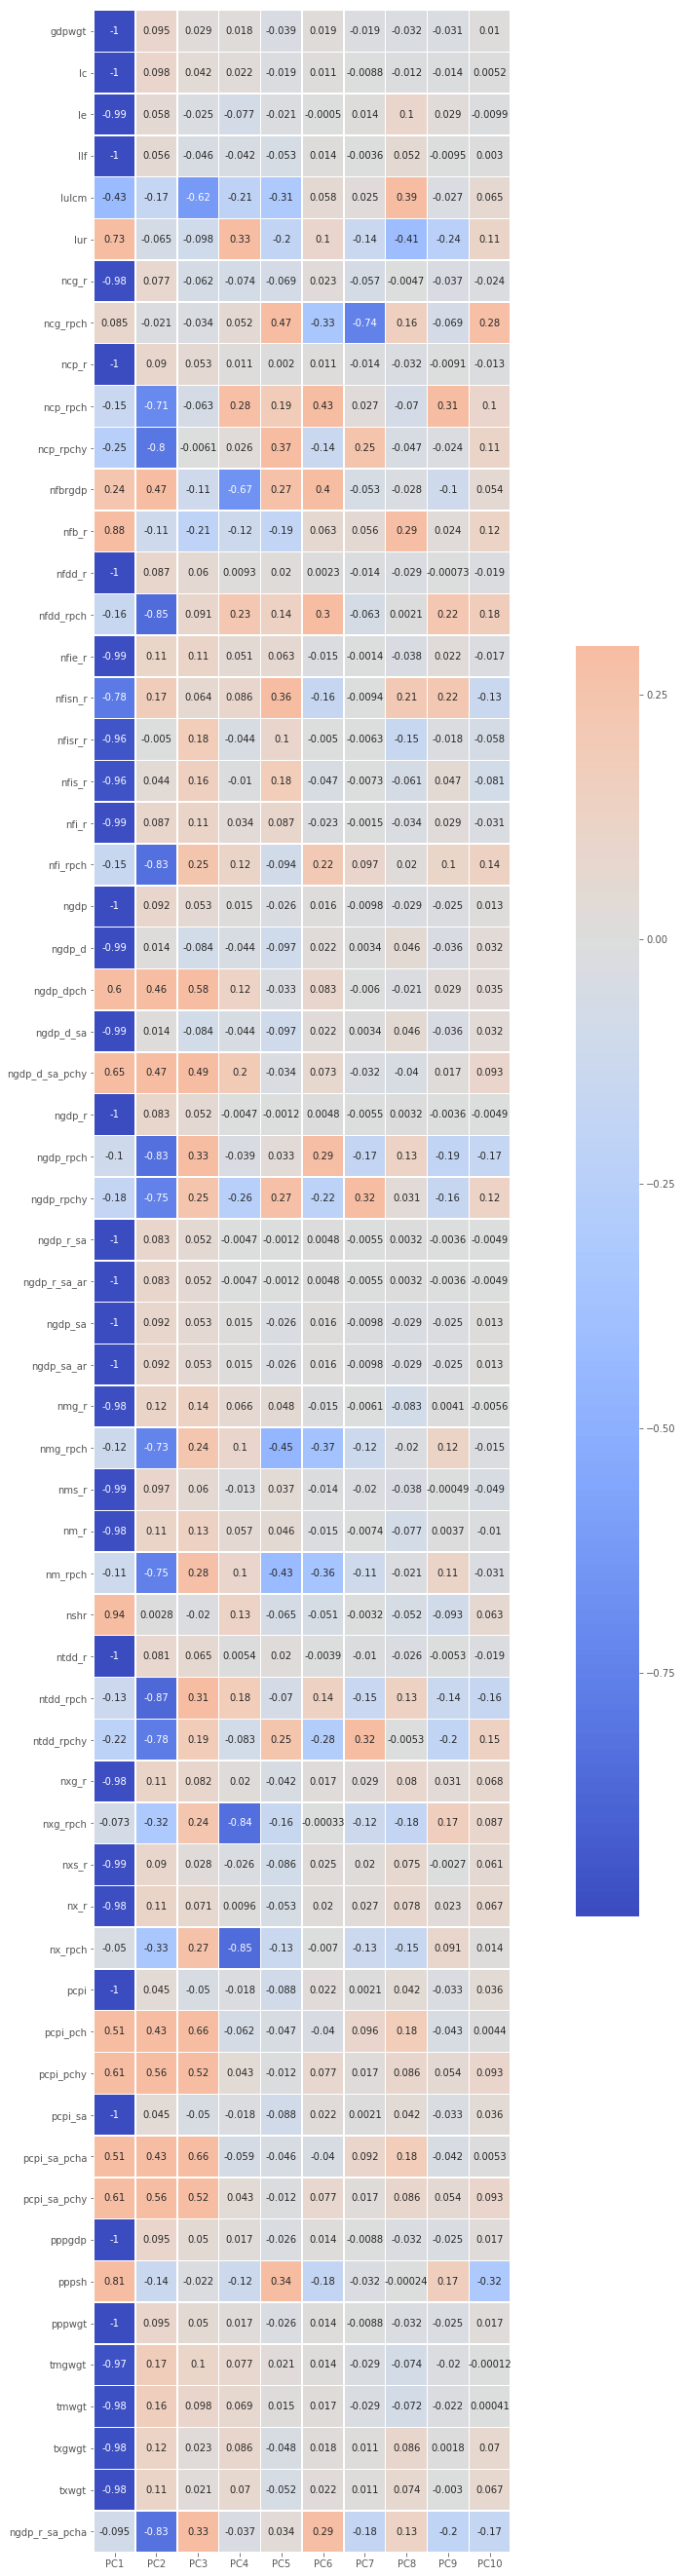

In [46]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(24,48))
sns_plot = sns.heatmap(loadings, vmax=.3, center=0, cmap= 'coolwarm', annot = True,
                       square=True, linewidths=.5, cbar_kws={"shrink": .5},
                       xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
                       yticklabels=X_train.columns)
sns_plot.get_figure().savefig("loading matrix.png")